In [18]:
# write your code here
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
import random

# 读取数据集
mem=Memory('./mycache1')
@mem.cache
def get_data(filename):
    data=load_svmlight_file(filename, n_features=123)
    return data[0], data[1]

# 划分数据集
x_train, y_train = get_data('../data/a9a')
x_test, y_test = get_data('../data/a9a.t')

x_train = x_train.toarray()
x_test = x_test.toarray()

x_train=np.c_[ x_train, np.ones(x_train.shape[0]) ]     # 在样本数据最后添加一整列的1，代替参数b
x_test=np.c_[ x_test, np.ones(x_test.shape[0]) ]     # 在样本数据最后添加一整列的1，代替参数b

# 求梯度的函数
def grad(times, w, theLambda):
    gradw = np.zeros(124)
    for i in range(0, times):
        index = random.randint(0, x_train.shape[0] - 1)
        tmp = np.exp( -1 * y_train[index] * np.dot(w, x_train[index]) )
        gradw += -1 * y_train[index] * x_train[index] * tmp
    return ( theLambda * w * w + gradw ) / ( (1+tmp) * times )

# 求准确率
def assess(w):
    right = 0.
    for i in range(0, x_test.shape[0]):
        if 1 / ( 1 + np.exp(-1 * np.dot(w, x_test[i])) ) >= 0.5:
            if y_test[i] == +1:
                right += 1
        else:
            if y_test[i] == -1:
                right += 1
    return right / x_test.shape[0]

# 计算loss
def getLoss(w):
    label_validate = []
    for i in range(0, x_test.shape[0]):
        if 1 / ( 1 + np.exp(-1 * np.dot(w, x_test[i])) ) >= 0.5:
            label_validate.append(1.)
        else:
            label_validate.append(-1.)
    cur=0.
    for i in range(0, x_test.shape[0]):
        cur += max(0, 1. - y_test[i] * label_validate[i])
    return cur / x_test.shape[0]

# NAG参数初始化
w_nag = np.random.rand(124)     # 模型参数初始化
mu = 0.9     # 动量的加权值
v = np.zeros(124)    # 动量
yita_nag = 0.001      # 学习率，即梯度的加权值
batch_size = 1     # 求梯度的样本数
lambda_nag = 1.1     # 正则项的权重

ranges = range(0, 300)
loss_nag = []
accuracy_nag = []
for i in ranges:
    # 计算梯度
    gradw = grad(batch_size, w_nag - mu * v, lambda_nag)
    # 更新w
    v = mu * v + yita_nag * gradw
    w_nag -= v
    # 计算loss
    loss = getLoss(w_nag)
    loss_nag.append(loss)
    # 计算准确率
    accuracy = assess(w_nag)
    accuracy_nag.append(accuracy)
        
print('计算结束')

计算结束


In [36]:
# RMSProp参数初始化
w_rmsp = np.random.rand(124)
capital_g = np.random.rand(124)
epsilon = 1e-8
yita_rmsp = 0.01     
batch_size = 2**3    
lambda_rmsp = 1.2

ranges = range(0, 300)
loss_rmsp = []
accuracy_rmsp = []
for i in ranges:
    gradw = grad(batch_size, w_rmsp, lambda_rmsp)
    capital_g = mu * capital_g + (1-mu) * ( gradw * gradw)
    w_rmsp -= ( yita_rmsp / np.sqrt( capital_g + epsilon ) ) * gradw
    
    loss = getLoss(w_rmsp)
    loss_rmsp.append(loss)
    accuracy = assess(w_rmsp)
    accuracy_rmsp.append(accuracy)
    
print('计算结束')

计算结束


In [54]:
# AdaDelta参数初始化
w_adadelta = np.random.rand(124)
capital_g_adadelta = np.random.rand(124) 
gama_adadelta = 0.95
delta_t = np.random.rand(124)
lambda_adadelta = 1.5
epsilon = 1e-8
batch_size = 2**4

ranges = range(0, 300)
loss_adadelta = []
accuracy_adadelta = []

for i in ranges:
    gradw = grad(batch_size, w_adadelta, lambda_adadelta)     # 提高样本数目，减少震荡
    capital_g_adadelta = gama_adadelta * capital_g_adadelta + (1-gama_adadelta) * gradw * gradw
    delta_w = -1 * ( np.sqrt( delta_t + epsilon ) / ( np.sqrt( capital_g_adadelta + epsilon ) ) ) * gradw
    delta_w /= 5
    w_adadelta += delta_w
    delta_t = gama_adadelta * delta_t + (1-gama_adadelta) * delta_w * delta_w
    
    loss = getLoss(w_adadelta)
    loss_adadelta.append(loss)
    accuracy = assess(w_adadelta)
    accuracy_adadelta.append(accuracy)
    
print('计算结束')

计算结束


In [89]:
# Adam初始化
w_adam = np.random.rand(124)
yita_adam = 0.1     
beta = 0.9
gama_adam = 0.999
moment = np.random.rand(124)
capital_g_adam = np.random.rand(124)
lambda_adam = 1.2
batch_size = 2**10

ranges = range(0, 300)
loss_adam = []
accuracy_adam = []

for e in ranges:
    gradw = grad(batch_size, w_adam, lambda_adam)
    moment = beta * moment + (1-beta) * gradw
    capital_g_adam = gama_adam * capital_g_adam + (1-gama_adam) * gradw * gradw
    alpha = yita_adam * ( np.sqrt(1-gama_adam**(e+1) ) / (1-beta**(e+1)) )
    w_adam -= alpha * moment / np.sqrt(capital_g_adam + epsilon)
    loss = getLoss(w_adam)
    loss_adam.append(loss)
    accuracy = assess(w_adam)
    accuracy_adam.append(accuracy)
    
print('计算结束')

计算结束


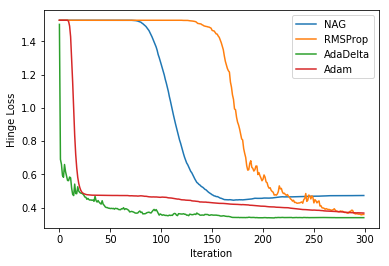

In [90]:
# 可视化实验结果，loss曲线
import matplotlib.pyplot as plt
figure1,=plt.plot(ranges, loss_nag)
figure2,=plt.plot(ranges, loss_rmsp)
figure3,=plt.plot(ranges, loss_adadelta)
figure4,=plt.plot(ranges, loss_adam)
plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.legend(handles=[figure1, figure2, figure3, figure4], labels=['NAG', 'RMSProp', 'AdaDelta', 'Adam'], loc='best')
plt.show()

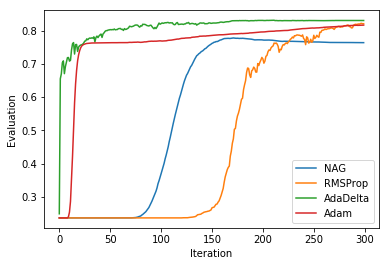

In [91]:
# 可视化实验结果，准确率
import matplotlib.pyplot as plt
figure1,=plt.plot(ranges, accuracy_nag)
figure2,=plt.plot(ranges, accuracy_rmsp)
figure3,=plt.plot(ranges, accuracy_adadelta)
figure4,=plt.plot(ranges, accuracy_adam)
plt.xlabel('Iteration')
plt.ylabel('Evaluation')
#plt.xticks(np.linspace(0, 199, 10))
plt.legend(handles=[figure1, figure2, figure3, figure4], labels=['NAG', 'RMSProp', 'AdaDelta', 'Adam'], loc='best')
plt.show()

In [92]:
print(accuracy_nag[299])
print(accuracy_rmsp[299])
print(accuracy_adadelta[299])
print(accuracy_adam[299])

0.7637737239727289
0.8207726798108225
0.8304158221239482
0.8165346108961365
